In [15]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [16]:
def centering_step(Q, p, A, b, t, v0, eps):
    # definition of f0 and derivatives
    def f0(v):
        return v.dot(Q.dot(v)) + p.dot(v)
    def Gf0(v):
        return Q.dot(v) + Q.T.dot(v) + p
    def Hf0(v):
        return Q + Q.T
    
    # definition of phi and derivatives
    def phi(v):
        return -np.sum(np.log(b - A.dot(v))) if (b - A.dot(v) > 0).all() else np.nan
    def Gphi(v):
        return A.T.dot(1/(b - A.dot(v)))
    def Hphi(v):
        return np.einsum("ijk,i", np.einsum('ij,ik->ijk', A, A), 1/((b - A.dot(v))**2))

    
    # definition of f and derivatives
    def f(v):
        return t*f0(v) + phi(v)
    def Gf(v):
        return t*Gf0(v) + Gphi(v)
    def Hf(v):
        return t*Hf0(v) + Hphi(v)
    
    # computation of a newton step
    def newton_step(v):
        Hfv_inv = np.linalg.inv(Hf(v))
        Gfv = Gf(v)
        dv = -Hfv_inv.dot(Gfv)
        lamSquare = Gfv.dot(Hfv_inv.dot(Gfv))
        return dv, lamSquare, Gfv
    
    # parameters for line search 
    alpha = 0.01
    beta = 0.5

    # backtracking line search
    def line_search(v, dv, Gfv):
        fv = f(v)
        tl = 1
        # To be sure to be in the domain
        while(np.isnan(f(v + tl*dv))):
            tl *= beta
        while(f(v + tl*dv) > fv + alpha*tl*Gfv.dot(dv)):
            tl *= beta
        return tl
        
    v = v0.copy()
    v_seq = [v0.copy()]
    while "The newton method didn't converge":
        dv, lamSquare, Gfv = newton_step(v)
        tl = line_search(v, dv, Gfv)
        v += tl*dv
        v_seq.append(v.copy())
        # Condition to quit
        if lamSquare < 2*eps:
            break
    return np.array(v_seq)

In [17]:
# Test 
n = 10
m = 5

Q = 5*np.identity(n, dtype=float)
p = np.random.randn(n)
v0 = np.zeros(n, dtype=float)
A = np.arange(m*n, dtype=float).reshape((m,n))
b = 1*np.ones(m, dtype=float)
t = 1
eps = 10**(-5)
v_seq = centering_step(Q, p, A, b, t, v0, eps)

In [173]:
def barr_method(Q, p, A, b, v0, t0, mu, eps_barr, eps_newton):
    m, n = A.shape
    v = v0.copy()
    v_seq = [v0.copy()]
    number_newton = []
    t = t0
    # Until it converge
    while m >= t*eps_barr:
        v_centering = centering_step(Q, p, A, b, t, v, eps_newton)
        v = v_centering[-1]
        v_seq.append(v)
        number_newton.append(len(v_centering))
        t *= mu
    return np.array(v_seq), np.array(number_newton), t/mu

In [174]:
# Test 
n = 10
m = 5

Q = 5*np.identity(n, dtype=float)
p = np.random.randn(n)
v0 = np.zeros(n, dtype=float)
A = np.arange(m*n, dtype=float).reshape((m,n))
b = 1*np.ones(m, dtype=float)
t0 = 1
eps = 10**(-5)

mu = 30 

v_seq, _, _ = barr_method(Q, p, A, b, v0, t0, mu, eps, eps)

In [187]:
def lasso(X, y, lam, mu, eps_barr, eps_newton):
    # Transform the problem to QP
    n,d = X.shape
    t0 = 1
    v0 = np.zeros(n)
    A = np.concatenate((X.T, -1*X.T))    
    Q = 0.5*np.identity(n)
    p = -y
    b = lam*np.ones(2*d)
    
    # Solve it
    v_seq, number_newton, t_final = barr_method(Q, p, A, b, v0, t0, mu, eps_barr, eps_newton)
    
    f = (lambda v: v.dot(Q.dot(v)) + p.dot(v))
    fv_seq = np.array([f(v) for v in v_seq])
    v_star, f_star = v_seq[np.argmin(fv_seq)], np.min(fv_seq)
    
    # Dual of QP
    alpha_star = 1/(-t_final*(A.dot(v_star) - b))
    
    # Recover w_star
    w_star = alpha_star[:d] - alpha_star[d:]
    
    return w_star, v_star, v_seq, fv_seq, f_star, np.concatenate([number_newton, [1]])

In [188]:
def iteration_gap_mu(mus, X, y, lam, eps_barr, eps_newton):
    for mu in mus:
        w_star, v_star, v_seq, fv_seq, f_star, number_newton = lasso(X, y, lam, mu, eps_barr, eps_newton)
        itermax = np.sum(number_newton)
        Xaxe = np.linspace(0, itermax, itermax)
        Yaxe = fv_seq - f_star
        Yaxe = np.repeat(Yaxe, number_newton)
        plt.semilogy(Xaxe, Yaxe, label="mu = "+str(mu), drawstyle='steps-pre')
        plt.legend(loc='upper right')
    plt.title("Changes in mu for X of shape " + str(X.shape))
    plt.xlabel('Number of Newton iterations')
    plt.ylabel('Gap between $f(v)$ and $f^*$')
    plt.show()

In [189]:
mus = [2, 5, 15, 50, 100, 200]
lam = 10
n = 50
d = 500
sigma = 80
mu = 40
sigma = 10
mu = 50
w_we_want_to_recover = 2*np.random.random(d) + 3
noise = np.random.random(n)
X = (sigma*np.random.random(n*d) + mu).reshape(n,d)
y = X.dot(w_we_want_to_recover) + noise
eps_barr = 10**(-5)
eps_newton = 10**(-5)

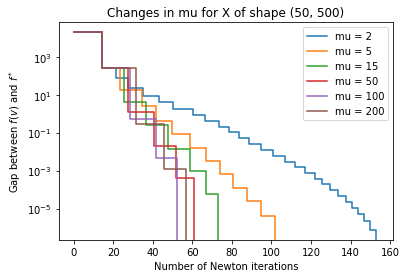

In [190]:
iteration_gap_mu(mus, X, y, lam, eps_barr, eps_newton)

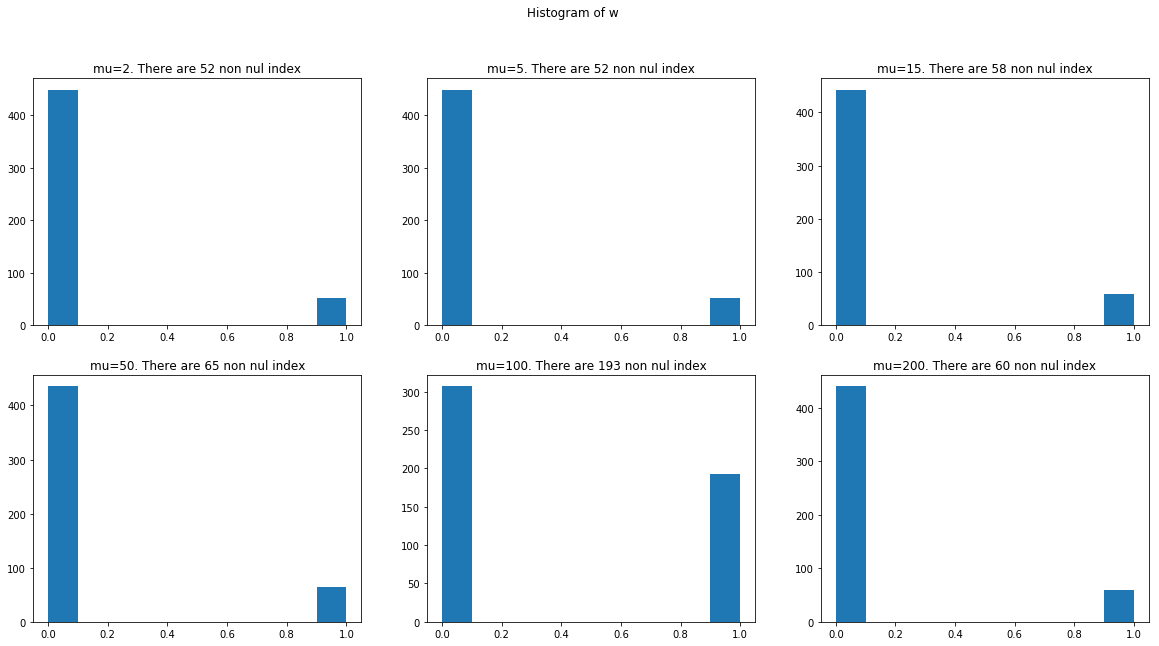

Function we want to minimize of w_star
[19965.51986883226, 19963.30816485075, 19969.842718808835, 19963.316824515645, 19973.509728028173, 19963.510143853102]


In [216]:
def function_lasso(X, y, lam, w):
    return np.linalg.norm(X.dot(w)-y, ord=2) + lam*np.linalg.norm(w, ord=1)

def sparsity_w_mu(mus, X, y, lam, eps_barr, eps_newton):
    f, axes = plt.subplots(2, 3, figsize=(20,10))
    w_stars = []
    for i, mu in enumerate(mus):
        axe = axes[i//3][i%3]
        w_star, v_star, v_seq, fv_seq, f_star, number_newton = lasso(X, y, lam, mu, eps_barr, eps_newton)
        #print(np.linalg.norm(v_star-(X.dot(w_star)-y), ord=2))           
        w_stars.append(w_star)
        
        boolnonzero = np.logical_not(np.isclose(w_star, np.zeros(X.shape[1]), atol=1e-05, rtol=0)).astype(int)
        number_of_nonzero = boolnonzero.sum()
        
        axe.hist(boolnonzero)
        axe.set_title("mu={}. There are {} non nul index".format(mu, number_of_nonzero))
    plt.suptitle("Histogram of w")
    plt.show()
    
    res = [function_lasso(X, y, lam, w_star) for w_star in w_stars]
    print("Function we want to minimize of w_star")
    print(res)
    
sparsity_w_mu(mus, X, y, lam, eps_barr, eps_newton)

In [212]:
print(function_lasso(X, y, lam, w_we_want_to_recover))

20229.737403365856


We can notice than we are doing better than our w from the beginning.